# FACIES CLASSIFICATION EXPERIMENT

---
## A. Import Library

### A.1 Library for Data Wrangling and Visualization

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [181]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import joblib

### A.2 Library for Imbalance Learning

In [3]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

### A.3 Library for data preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize

### A.4 Library for Machine Learning Modeling

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

### A.5 Library for Calculating Performance

In [6]:
from sklearn.metrics import confusion_matrix
from facies_utilities import accuracy, accuracy_adjacent, display_cm, display_adj_cm, make_facies_log_plot, compare_facies_plot
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### A.6 User Defined Function

In [124]:
def roc_auc_model_plot(model, data_type, model_name:str):
    y_train_binarize = label_binarize(train_data["y_train"][data_type], classes=[0,1,2,3,4,5,6,7,8])
    n_classes = y_train_binarize.shape[1]
    classifier = OneVsRestClassifier(model)
    classifier.fit(train_data["X_train"][data_type].values, y_train_binarize)
    if model_name == "Support Vector Machine Classifier":
        y_score = classifier.decision_function(test_data['X_test'].values)
    else :
        y_score = classifier.predict_proba(test_data['X_test'].values)
    y_test_binarize = label_binarize(test_data["y_test"], classes=[0,1,2,3,4,5,6,7,8])
    n_classes = y_test_binarize.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(9):
        fpr[i], tpr[i], _  = roc_curve(y_test_binarize[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarize.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(9)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(9):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=[7,7])
    plt.plot( fpr["micro"], tpr["micro"],
        label=f"micro-average ROC curve (area = {roc_auc['micro']:.2f})",
        color="deeppink", linestyle=":", linewidth=3)
    plt.plot(fpr["macro"], tpr["macro"],
        label=f"macro-average ROC curve (area = {roc_auc['macro']:.2f})",
        color="orange", linestyle=":", linewidth=3)

    plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} Operating Characteristic", fontsize=15)
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["micro"], roc_auc["macro"]

---
## B. DATA PIPELINE

### B.1 Import Raw Data

In [8]:
def populate_raw_data(directory:str="well_data/") -> pd.DataFrame:     # Put this function on script
    raw_data = pd.DataFrame()
    for well_data in os.listdir(directory):
        raw_data = pd.concat([raw_data,pd.read_csv(directory+well_data)],
                             axis=0,
                             ignore_index=True)
    return raw_data

In [9]:
raw_data = populate_raw_data()
raw_data.head(5)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,CSiS,A1 SH,NOLAN,2853.5,106.813,0.533,9.339,15.222,3.500,1,1.000
1,FSiS,A1 SH,NOLAN,2854.0,100.938,0.542,8.857,15.313,3.416,1,0.977
2,FSiS,A1 SH,NOLAN,2854.5,94.375,0.553,7.097,14.583,3.195,1,0.955
3,FSiS,A1 SH,NOLAN,2855.0,89.813,0.554,7.081,14.110,2.963,1,0.932
4,FSiS,A1 SH,NOLAN,2855.5,91.563,0.560,6.733,13.189,2.979,1,0.909


In [10]:
raw_data.shape

(4149, 11)

In [11]:
raw_data.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [12]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   object 
 1   Formation  4149 non-null   object 
 2   Well Name  4149 non-null   object 
 3   Depth      4149 non-null   float64
 4   GR         4149 non-null   float64
 5   ILD_log10  4149 non-null   float64
 6   DeltaPHI   4149 non-null   float64
 7   PHIND      4149 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       4149 non-null   int64  
 10  RELPOS     4149 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 356.7+ KB


In [13]:
raw_data.isnull().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

We found that there are missing data in **PE** column, hence this raw data need data cleaning first

### B.2 Data Overview

There are seven predictor variable for the facies label : 

Features | Explanation | Value | Measurement Type
:---: | :--: | :--: | :--: 
GR | Gamma Ray | 10.14 - 361.15 | Wireline Measurement 
ILD_log10 | Resistivity Logging | -0.03 - 1.8 | Wireline Measurement 
PE | Photoelectric Effect | 0.2 - 8.09 | Wireline Measurement
DeltaPHI | Neutron-Density Porosity Difference | -21.83 - 19.31 | Wireline Measurement 
PHIND | Average Neutron-Density Porosity | 0.55 - 84.4 | Wireline Measurement
NM_M | Non-Marine Marine Indicator | 1 or 2 |  Geologic Constraining Variables 
RELPOS | Relative Position | 0 - 1 | Geologic Constraining Variables

And there are nine different facies labels :

Facies| Adjacent Facies | Classes of Rocks 
:---: |:--: |:--:
SS| CSiS | Sandstone
CSiS| SS,FSiS | Coarse Siltstone
FSiS| CSiS | Fine Siltstone
SiSh| MS | Marine Siltstone and Shale
MS| SiSh,WS | Mudstone (limestone)
WS| MS,D | Wackestone (limestone)
D| WS,PS | Dolomite
PS| WS,D,BS | Packstone-grainstone (limestone)
BS| D, PS | Phylloid-algal bafflestone (limestone)

<AxesSubplot:xlabel='count', ylabel='Well Name'>

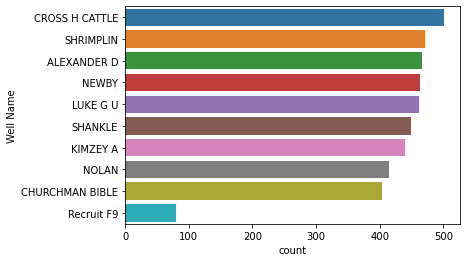

In [14]:
sns.countplot(data=raw_data, 
              y="Well Name", 
              order=raw_data["Well Name"].value_counts().index)

We have data from 10 well measurement : **NOLAN, LUKE G U, CROSS H CATTLE, KIMZEY A, SHRIMPLIN, NEWBY, Recruit F9, SHANKLE, CHURCHMAN BIBLE, and ALEXANDER D**. Value counts shows us that for every well the amount is simillar except Recruit F9 well which just has 80 raw data.

In [15]:
raw_data["Facies"].value_counts(normalize=True)

CSiS    0.226561
FSiS    0.187997
PS      0.165341
WS      0.140275
MS      0.071342
SiSh    0.065317
SS      0.064594
BS      0.044589
D       0.033984
Name: Facies, dtype: float64

Value counts also show us that this raw data has **imbalance category** for facies.

### B.3 Split Train and Test Data

we will use CHURCHMAN BIBLE well as test data and others well as train data

In [16]:
def split_well_train_test(data:pd.DataFrame, well_name:str):
    data_train_unclean = data[data["Well Name"]!=well_name]
    data_test_unclean = data[data["Well Name"]==well_name]
    
    return data_train_unclean, data_test_unclean

In [17]:
data_train_unclean, data_test_unclean = split_well_train_test(data=raw_data, well_name="CHURCHMAN BIBLE")

In [18]:
data_train_unclean.shape

(3745, 11)

In [19]:
data_train_unclean.head(5)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,CSiS,A1 SH,NOLAN,2853.5,106.813,0.533,9.339,15.222,3.500,1,1.000
1,FSiS,A1 SH,NOLAN,2854.0,100.938,0.542,8.857,15.313,3.416,1,0.977
2,FSiS,A1 SH,NOLAN,2854.5,94.375,0.553,7.097,14.583,3.195,1,0.955
3,FSiS,A1 SH,NOLAN,2855.0,89.813,0.554,7.081,14.110,2.963,1,0.932
4,FSiS,A1 SH,NOLAN,2855.5,91.563,0.560,6.733,13.189,2.979,1,0.909


In [20]:
data_test_unclean.shape

(404, 11)

In [21]:
data_test_unclean.head(5)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
3279,FSiS,A1 SH,CHURCHMAN BIBLE,2917.5,63.500,0.705,4.916,12.174,3.162,1,1.00
3280,FSiS,A1 SH,CHURCHMAN BIBLE,2918.0,80.875,0.709,7.514,13.286,2.932,1,0.95
3281,FSiS,A1 SH,CHURCHMAN BIBLE,2918.5,87.813,0.700,7.785,13.212,2.953,1,0.90
3282,FSiS,A1 SH,CHURCHMAN BIBLE,2919.0,86.750,0.685,7.547,13.547,3.420,1,0.85
3283,FSiS,A1 SH,CHURCHMAN BIBLE,2919.5,79.438,0.669,5.912,12.252,3.324,1,0.80


In [22]:
print(f"Percentage Train Data : {data_train_unclean.shape[0]/(data_train_unclean.shape[0]+data_test_unclean.shape[0]):.2f}")
print(f"Percentage Test Data : {data_test_unclean.shape[0]/(data_train_unclean.shape[0]+data_test_unclean.shape[0]):.2f}")

Percentage Train Data : 0.90
Percentage Test Data : 0.10


In [23]:
data_train_unclean.isnull().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

In [24]:
data_test_unclean.isnull().sum()

Facies       0
Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64

After splitting train and test data, we encounter a null values in train data hence we need to handle this null value through data cleaning

### B.4 Cleaning Data

From the null identification we know that there are **917 null data** in **PE (Photo Electric)** measurement. I will impute the data by using average value of PE for every facies category, taken from non null PE data

#### B.4.1 Cleaning Train Data

In [25]:
def impute_PE_data_train(data:pd.DataFrame) -> pd.DataFrame:
    if data["PE"].isnull().sum() == 0:
        pass
    else :
        PE_mean_data = data.loc[~(data["PE"].isnull()),["Facies","PE"]].groupby("Facies").agg('mean')
        PE_nan_data = data.loc[data["PE"].isnull(),["Facies","PE"]]
        facies_labels = data["Facies"].unique().tolist()
        for facies in facies_labels:
            index_PE_nan_by_categories = PE_nan_data[PE_nan_data['Facies']==facies].index.to_list()    
            data.loc[index_PE_nan_by_categories,'PE'] = PE_mean_data.loc[facies].values[0]
    return data

In [26]:
data_train_clean = impute_PE_data_train(data=data_train_unclean)

In [27]:
data_train_clean.isnull().sum()

Facies       0
Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64

In [28]:
data_train_clean.shape

(3745, 11)

#### B.4.2 Cleaning Test Data

In [29]:
def impute_PE_data_test(data:pd.DataFrame, train_data:pd.DataFrame) -> pd.DataFrame:
    if data["PE"].isnull().sum() == 0:
        pass
    else :
        PE_mean_data = train_data.loc[~(train_data["PE"].isnull()),["Facies","PE"]].groupby("Facies").agg('mean')
        PE_nan_data = data.loc[data["PE"].isnull(),["Facies","PE"]]
        facies_labels = data["Facies"].unique().tolist()
        for facies in facies_labels:
            index_PE_nan_by_categories = PE_nan_data[PE_nan_data['Facies']==facies].index.to_list()    
            data.loc[index_PE_nan_by_categories,'PE'] = PE_mean_data.loc[facies].values[0]
    return data

In [30]:
data_test_clean = impute_PE_data_test(data=data_test_unclean, train_data=data_train_unclean)

In [31]:
data_test_clean.isnull().sum()

Facies       0
Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64

In [32]:
data_test_clean.shape

(404, 11)

### B.5 Check Data Type

In [33]:
data_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3745 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     3745 non-null   object 
 1   Formation  3745 non-null   object 
 2   Well Name  3745 non-null   object 
 3   Depth      3745 non-null   float64
 4   GR         3745 non-null   float64
 5   ILD_log10  3745 non-null   float64
 6   DeltaPHI   3745 non-null   float64
 7   PHIND      3745 non-null   float64
 8   PE         3745 non-null   float64
 9   NM_M       3745 non-null   int64  
 10  RELPOS     3745 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 480.1+ KB


In [34]:
data_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 3279 to 3682
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     404 non-null    object 
 1   Formation  404 non-null    object 
 2   Well Name  404 non-null    object 
 3   Depth      404 non-null    float64
 4   GR         404 non-null    float64
 5   ILD_log10  404 non-null    float64
 6   DeltaPHI   404 non-null    float64
 7   PHIND      404 non-null    float64
 8   PE         404 non-null    float64
 9   NM_M       404 non-null    int64  
 10  RELPOS     404 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 37.9+ KB


---
## C. Feature Engineering

### C.1 Feature Selection

#### RELPOS Feature

In [35]:
data_train_clean.groupby(["Well Name","Formation"]).aggregate({'Depth':['min','max'],'RELPOS':['min','max']})

Depth         RELPOS     
                          min     max    min  max
Well Name   Formation                            
ALEXANDER D A1 LM      2907.0  2939.0  0.015  1.0
            A1 SH      2887.5  2906.5  0.026  1.0
            B1 LM      2956.0  2966.0  0.048  1.0
            B1 SH      2939.5  2955.5  0.031  1.0
            B2 LM      2978.0  2987.5  0.050  1.0
...                       ...     ...    ...  ...
SHRIMPLIN   B4 SH      2911.0  2925.0  0.034  1.0
            B5 LM      2938.0  2948.0  0.050  1.0
            B5 SH      2930.0  2937.5  0.118  1.0
            C LM       2977.0  3028.0  0.010  1.0
            C SH       2948.5  2976.5  0.018  1.0

[114 rows x 4 columns]

In [36]:
data_train_clean.loc[(data_train_clean["Well Name"]=='ALEXANDER D') & (data_train_clean["Formation"]=='A1 SH')][['Depth','RELPOS']].corr()

,Depth,RELPOS
Depth,1.0,-1.0
RELPOS,-1.0,1.0


from this analysis we know that variable depth and RELPOS are strongly correlated, we can say that RELPOS is MinMaxScaller of depth for every formation group, hence for modeling purpose we could drop **Depth, RELPOS and, Formation**

#### Formation Features

In [37]:
data_train_clean["Formation"].unique()

array(['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', 'B2 SH', 'B2 LM', 'B3 SH',
       'B3 LM', 'B4 SH', 'B4 LM', 'B5 SH', 'B5 LM', 'C SH', 'C LM'],
      dtype=object)

formation data contains formation name in every well data, this is just a naming convention for labeling the reservoar under the surface. This data is meaningless for lithofacies classification so I would drop it from the feature modeling

#### Depth Features

In [38]:
data_train_clean["Depth"].value_counts().sum()

3745

because depth is highly unique, and I know that there are no correlation between depth and lithofacies category, hence for modeling purpose I would drop this features

#### Well Name Feaures

In [39]:
data_train_clean["Well Name"].unique()

array(['NOLAN', 'LUKE G U', 'CROSS H CATTLE', 'KIMZEY A', 'SHRIMPLIN',
       'NEWBY', 'Recruit F9', 'SHANKLE', 'ALEXANDER D'], dtype=object)

well data feature is just an identifier for the source of the data, hence this feature isn't important for this lithofacies classification. From this feature selection activity we know that our input for classification problem is come from wireline measurement feature (GR, ILD_log10, PE, DeltaPHI, PHIND) and the output for classification is Facies Label, the rest of the feature will be dropped from modeling

In [40]:
def split_input_output_well_data(data:pd.DataFrame):
    data = data[["GR","ILD_log10","DeltaPHI","PHIND","PE","NM_M","Facies"]]
    y_train = data["Facies"]
    X_train_categorical = data["NM_M"]
    X_train_numerical = data.drop(["Facies","NM_M"], axis=1)
    
    return X_train_numerical, X_train_categorical, y_train

In [41]:
X_train_numerical, X_train_categorical, y_train = split_input_output_well_data(data=data_train_clean)

In [42]:
X_train_numerical.head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE
0,106.813,0.533,9.339,15.222,3.500
1,100.938,0.542,8.857,15.313,3.416
2,94.375,0.553,7.097,14.583,3.195
3,89.813,0.554,7.081,14.110,2.963
4,91.563,0.560,6.733,13.189,2.979


In [43]:
X_train_categorical.head(5)

0    1
1    1
2    1
3    1
4    1
Name: NM_M, dtype: int64

In [44]:
y_train.head(5)

0    CSiS
1    FSiS
2    FSiS
3    FSiS
4    FSiS
Name: Facies, dtype: object

### C.2 Handling Categorical Data

In [45]:
def categorical_handling(data:pd.Series) -> pd.DataFrame:
    non_marine_marine_label = {1:"non_marine",2:"marine"}
    data_marine = data.map(non_marine_marine_label)
    ohe_train = OneHotEncoder(sparse=False)
    ohe_train.fit(np.array(["non_marine","marine"]).reshape(-1,1))
    ohe_data = ohe_train.transform(np.array(data_marine.to_list()).reshape(-1,1))
    ohe_data = pd.DataFrame(data=ohe_data, columns=list(ohe_train.categories_[0]), index=data_marine.index)
    
    return ohe_data, ohe_train

In [46]:
X_train_categorical, ohe_train = categorical_handling(data=X_train_categorical)

In [47]:
X_train_categorical.head(5)

,marine,non_marine
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


### C.3 Normalize Feature Value

In [48]:
def normalize_data(numerical_data:pd.DataFrame, categorical_data:pd.DataFrame) -> pd.DataFrame:
    data = pd.concat([numerical_data, categorical_data], axis=1)
    standard_scaler_train = StandardScaler()
    standard_scaler_train.fit(data.values)
    normalized_data = standard_scaler_train.transform(data.values)
    normalized_data = pd.DataFrame(data=normalized_data, index=data.index, columns=data.columns)
    
    return normalized_data, standard_scaler_train

In [49]:
X_train, standard_scaler_train = normalize_data(numerical_data=X_train_numerical,
                        categorical_data=X_train_categorical)

after scaling, we could see that for every wireline measurement feature, now they are having standard deviation equal to 1 and mean equal to 0

In [50]:
X_train.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
count,3.745000e+03,3.745000e+03,3.745000e+03,3.745000e+03,3.745000e+03,3.745000e+03,3.745000e+03
mean,3.959450e-16,5.334703e-16,1.440177e-16,1.889454e-16,4.306895e-16,-1.428200e-15,1.191037e-15
std,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00,1.000134e+00
min,-1.833418e+00,-2.682445e+00,-4.616491e+00,-1.889120e+00,-4.390288e+00,-9.928162e-01,-1.007236e+00
25%,-6.344830e-01,-6.354781e-01,-5.269708e-01,-6.786932e-01,-6.894735e-01,-9.928162e-01,-1.007236e+00
50%,8.716819e-03,-9.772006e-02,-1.711376e-03,-1.443009e-01,-1.792872e-01,-9.928162e-01,9.928162e-01
75%,4.964497e-01,6.126991e-01,6.008362e-01,4.339975e-01,6.827294e-01,1.007236e+00,9.928162e-01
max,9.884223e+00,4.575861e+00,2.739392e+00,1.071887e+01,5.386665e+00,1.007236e+00,9.928162e-01


In [51]:
X_train.head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
0,1.393564,-0.460574,0.868531,0.317015,-0.303140,-0.992816,0.992816
1,1.197436,-0.424799,0.778111,0.330698,-0.407177,-0.992816,0.992816
2,0.978341,-0.381073,0.447948,0.220932,-0.680892,-0.992816,0.992816
3,0.826045,-0.377097,0.444947,0.149810,-0.968231,-0.992816,0.992816
4,0.884466,-0.353247,0.379664,0.011325,-0.948414,-0.992816,0.992816


### C.4 Label Encoding Output Feature

In [52]:
def facies_encoder(data:pd.Series) -> pd.Series :
    facies_label_encoder = {'SS':0, 'CSiS':1, 'FSiS':2, 'SiSh':3, 'MS':4, 'WS':5, 'D':6, 'PS':7, 'BS':8}
    encoded_data = data.map(facies_label_encoder)
    
    return encoded_data

In [53]:
y_train_numerical = facies_encoder(data=y_train)

In [54]:
y_train_numerical.head(5)

0    1
1    2
2    2
3    2
4    2
Name: Facies, dtype: int64

as you can see, the facies data now already encoded by using label encoder in dictionary 'facies_label_encoder'

### C.5 Balancing Train Data

#### Unbalance Train Data

In [55]:
inverse_facies_label_encoder = {0:'SS', 1:'CSiS', 2:'FSiS', 3:'SiSh', 4:'MS', 5:'WS', 6:'D', 7:'PS', 8:'BS'}
facies_colors_pallete = {'SS':'#F4D03F', 'CSiS':'#F5B041', 'FSiS':'#DC7633','SiSh':'#6E2C00',
       'MS':'#1B4F72', 'WS':'#2E86C1', 'D':'#AED6F1', 'PS':'#A569BD', 'BS':'#196F3D'}

In [56]:
y_train.value_counts()

CSiS    884
FSiS    729
PS      611
WS      495
MS      266
SS      260
SiSh    258
BS      135
D       107
Name: Facies, dtype: int64

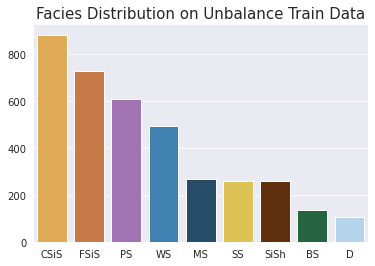

In [57]:
sns.set_style('darkgrid')
y_train_summary = y_train.value_counts()
sns.barplot(x=y_train_summary.index,
            y=y_train_summary.values,
            palette=facies_colors_pallete,
            order=y_train_summary.index)
plt.title("Facies Distribution on Unbalance Train Data", fontsize=15)
plt.show()

we could see that the categories are not balance each other from the train data, for experiment purpose let's we try unbalance, undersampling, oversampling and smote sampling data to search for best model. I will use x_train, and y_train as unbalance train data

#### Random Under Sampling Train Data

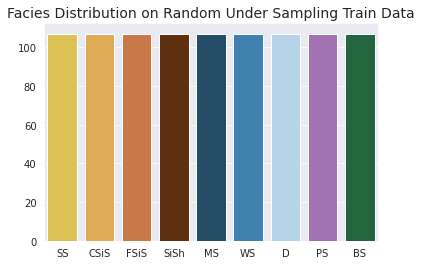

In [58]:
rus = RandomUnderSampler()
x_train_rus, y_train_rus = rus.fit_resample(X = X_train.values, y = y_train_numerical)
x_train_rus = pd.DataFrame(data=x_train_rus, columns=X_train.columns)
y_train_rus_summary = y_train_rus.value_counts()
y_train_rus_summary.index = y_train_rus_summary.index.map(inverse_facies_label_encoder)
sns.barplot(x=y_train_rus_summary.index,
            y=y_train_rus_summary.values,
            palette=facies_colors_pallete,
            order=y_train_rus_summary.index)
plt.title("Facies Distribution on Random Under Sampling Train Data", fontsize=14)
plt.show()

because the smallest category is D, then the random under sampling algorithm cut the amount of others category to be the same amout as D, hence we will have least input than the unbalance training data.

#### Random Over Sampling Training Data

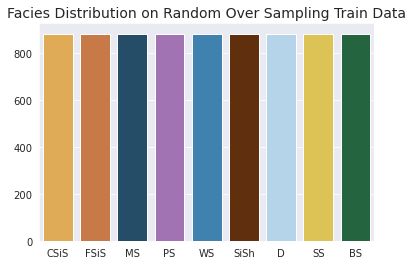

In [59]:
ros = RandomOverSampler()
x_train_ros, y_train_ros = ros.fit_resample(X = X_train.values, y=y_train_numerical)
x_train_ros = pd.DataFrame(data=x_train_ros, columns=X_train.columns)
y_train_ros_summary = y_train_ros.value_counts()
y_train_ros_summary.index = y_train_ros_summary.index.map(inverse_facies_label_encoder)
sns.barplot(x=y_train_ros_summary.index,
            y=y_train_ros_summary.values,
            palette=facies_colors_pallete,
            order=y_train_ros_summary.index)
plt.title("Facies Distribution on Random Over Sampling Train Data", fontsize=14)
plt.show()

because the largest category is CSiS, then the random over sampling algorithm extend the amount of others category to be the same amout as CSiS, hence we will have more input than unblance training data

#### SMOTE Sampling Training Data

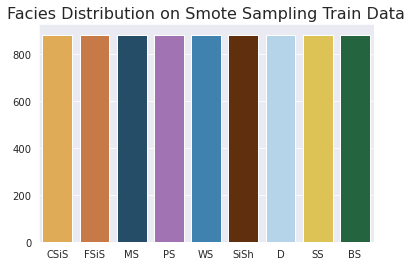

In [60]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(X = X_train.values,y = y_train_numerical)
x_train_smote = pd.DataFrame(data=x_train_smote, columns=X_train.columns)
y_train_smote_summary = y_train_smote.value_counts()
y_train_smote_summary.index = y_train_smote_summary.index.map(inverse_facies_label_encoder)
sns.barplot(x=y_train_smote_summary.index,
            y=y_train_smote_summary.values,
            palette=facies_colors_pallete,
            order=y_train_smote_summary.index)
plt.title("Facies Distribution on Smote Sampling Train Data", fontsize=16)
plt.show()

we will get smote train data as much as over sampling training data, but with much variation in the data

In [61]:
def make_modeling_data(X_data:pd.DataFrame, y_data:pd.DataFrame) -> dict :
    rus = RandomUnderSampler()
    ros = RandomOverSampler()
    smote = SMOTE()
    
    X_train_rus, y_train_rus = rus.fit_resample(X = X_data.values, y = y_data)
    X_train_ros, y_train_ros = ros.fit_resample(X = X_data.values, y=y_data)
    X_train_smote, y_train_smote = smote.fit_resample(X = X_data.values,y = y_data)
    
    X_train_rus = pd.DataFrame(data=X_train_rus, columns=X_data.columns)
    X_train_ros = pd.DataFrame(data=X_train_ros, columns=X_data.columns)
    X_train_smote = pd.DataFrame(data=X_train_smote, columns=X_data.columns)
    
    modeling_data = {"X_train":{"unbalance":X_data, "rus":X_train_rus, "ros":X_train_ros, "smote": X_train_smote},
                     "y_train":{"unbalance":y_data, "rus":y_train_rus, "ros":y_train_ros, "smote": y_train_smote}}
    
    return modeling_data

In [62]:
train_data = make_modeling_data(X_data=X_train, y_data=y_train_numerical)

In [63]:
train_data

{'X_train': {'unbalance':             GR  ILD_log10  DeltaPHI     PHIND        PE    marine  non_marine
  0     1.393564  -0.460574  0.868531  0.317015 -0.303140 -0.992816    0.992816
  1     1.197436  -0.424799  0.778111  0.330698 -0.407177 -0.992816    0.992816
  2     0.978341  -0.381073  0.447948  0.220932 -0.680892 -0.992816    0.992816
  3     0.826045  -0.377097  0.444947  0.149810 -0.968231 -0.992816    0.992816
  4     0.884466  -0.353247  0.379664  0.011325 -0.948414 -0.992816    0.992816
  ...        ...        ...       ...       ...       ...       ...         ...
  4144  0.109201   1.038033 -1.221064 -0.759138  1.003790  1.007236   -1.007236
  4145  0.093511   1.101635 -0.545730 -0.742598  1.003790  1.007236   -1.007236
  4146  0.031084   1.109585  0.298437 -0.687715  1.003790  1.007236   -1.007236
  4147  0.077487   0.990332  0.917493 -0.505023  1.003790  1.007236   -1.007236
  4148  0.384281   0.799528  1.386474 -0.345638  1.003790  1.007236   -1.007236
  
  [3745 rows 

this **train_data** dictionary will consist of X_train and y_train for unbalance, undersampling, oversampling, and SMOTE train data. I will try this all sampling into machine learning model

### C.6 Feature Engineering on Test Data

we will do what has been done on the training data into the testing data

In [64]:
X_test_numerical, X_test_categorical, y_test = split_input_output_well_data(data=data_test_clean)

In [65]:
X_test_numerical.head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE
3279,63.500,0.705,4.916,12.174,3.162
3280,80.875,0.709,7.514,13.286,2.932
3281,87.813,0.700,7.785,13.212,2.953
3282,86.750,0.685,7.547,13.547,3.420
3283,79.438,0.669,5.912,12.252,3.324


In [66]:
X_test_categorical.head(5)

3279    1
3280    1
3281    1
3282    1
3283    1
Name: NM_M, dtype: int64

In [67]:
y_test.head(5)

3279    FSiS
3280    FSiS
3281    FSiS
3282    FSiS
3283    FSiS
Name: Facies, dtype: object

In [68]:
y_test.unique()

array(['FSiS', 'CSiS', 'SS', 'PS', 'WS', 'MS', 'SiSh', 'D', 'BS'],
      dtype=object)

In [69]:
def categorical_handling_test_data(data:pd.Series, ohe:OneHotEncoder) -> pd.DataFrame:
    non_marine_marine_label = {1:"non_marine",2:"marine"}
    data_marine = data.map(non_marine_marine_label)
    ohe_data = ohe.transform(np.array(data_marine.to_list()).reshape(-1,1))
    ohe_data = pd.DataFrame(data=ohe_data, columns=list(ohe_train.categories_[0]), index=data_marine.index)
    
    return ohe_data

In [70]:
X_test_categorical = categorical_handling_test_data(data=X_test_categorical, ohe=ohe_train)

In [71]:
X_test_categorical.head(5)

,marine,non_marine
3279,0.0,1.0
3280,0.0,1.0
3281,0.0,1.0
3282,0.0,1.0
3283,0.0,1.0


In [72]:
def normalize_test_data(numerical_data:pd.DataFrame, categorical_data:pd.DataFrame, scaler:StandardScaler) -> pd.DataFrame:
    data = pd.concat([numerical_data, categorical_data], axis=1)
    normalized_data = scaler.transform(data.values)
    normalized_data = pd.DataFrame(data=normalized_data, index=data.index, columns=data.columns)
    
    return normalized_data

In [73]:
X_test = normalize_test_data(numerical_data=X_test_numerical,
                            categorical_data=X_test_categorical,
                            scaler=standard_scaler_train)

In [74]:
X_test.head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
3279,-0.052375,0.223141,0.038809,-0.141294,-0.721763,-0.992816,0.992816
3280,0.527663,0.239041,0.526174,0.025911,-1.006625,-0.992816,0.992816
3281,0.759278,0.203265,0.577012,0.014784,-0.980616,-0.992816,0.992816
3282,0.723791,0.143639,0.532365,0.065156,-0.402222,-0.992816,0.992816
3283,0.479691,0.080037,0.225651,-0.129565,-0.521121,-0.992816,0.992816


In [75]:
X_test.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,marine,non_marine
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,-0.046251,0.436831,-0.590752,0.134942,0.055941,0.452766,-0.452766
std,1.112805,0.959453,0.685595,1.590764,1.353359,0.896393,0.896393
min,-1.689201,-2.181787,-4.978920,-1.622977,-2.823548,-0.992816,-1.007236
25%,-0.790968,-0.055115,-0.813800,-0.906532,-0.809699,-0.992816,-1.007236
50%,-0.195824,0.501397,-0.522375,-0.367666,-0.005893,1.007236,-1.007236
75%,0.308584,1.134429,-0.214113,0.506586,0.960160,1.007236,0.992816
max,5.255601,2.620118,0.598585,6.099398,5.386665,1.007236,0.992816


In [76]:
y_test_numerical = facies_encoder(y_test)

In [77]:
y_test_numerical.head(5)

3279    2
3280    2
3281    2
3282    2
3283    2
Name: Facies, dtype: int64

In [78]:
def create_test_data (X_data:pd.DataFrame, y_data:pd.DataFrame) -> dict:
    test_data = {'X_test':X_data, 'y_test':y_data}
    return test_data

In [79]:
test_data = create_test_data(X_data=X_test,
                            y_data=y_test_numerical)

---
## D. Modeling

### D.1. Baseline Model

In [80]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X=train_data["X_train"]["unbalance"],
              y=train_data["y_train"]["unbalance"])
y_pred_dummy = dummy_clf.predict(train_data["X_train"]["unbalance"])

In [81]:
dummy_conf_matrix = confusion_matrix(y_true=train_data["y_train"]["unbalance"], 
                                     y_pred=y_pred_dummy)
display_cm(dummy_conf_matrix, hide_zeros=False, display_metrics=True)
print('Facies classification accuracy = %.2f' % accuracy(dummy_conf_matrix))
print("---------------------------------------------------------------------")
display_adj_cm(cm=dummy_conf_matrix)
print('Adjacent facies classification accuracy = %.2f' % accuracy_adjacent(dummy_conf_matrix))

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     0   260     0     0     0     0     0     0     0   260
     CSiS     0   884     0     0     0     0     0     0     0   884
     FSiS     0   729     0     0     0     0     0     0     0   729
     SiSh     0   258     0     0     0     0     0     0     0   258
       MS     0   266     0     0     0     0     0     0     0   266
       WS     0   495     0     0     0     0     0     0     0   495
        D     0   107     0     0     0     0     0     0     0   107
       PS     0   611     0     0     0     0     0     0     0   611
       BS     0   135     0     0     0     0     0     0     0   135

Precision  0.00  0.24  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.06
   Recall  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.24
       F1  0.00  0.38  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.09
Facies classification accuracy = 0.24
-----------------------------------------

From this dummy classifier model, we know that we need to make machine learning model with accuracy for more than 24% and adjacent accuracy for more than 50% for facies classification

### D.2. Create Model Object

In [82]:
knn = KNeighborsClassifier()       # create object k-nearest neighbors classifier
dct = DecisionTreeClassifier()     # create object decision tree classifier
bagt = BaggingClassifier()         # create object bagging tree classifier
logreg = LogisticRegression()      # create object logistic regression
svm = SVC()                        # create object support vector machine
rfc = RandomForestClassifier()     # create object random forest classifier
xgb = XGBClassifier()              # create object extreme gradient boosting classifier

In [83]:
def model_hyperparameter(model_name:str) -> dict:
    knn_hyper_parameter = {
        "algorithm" : ["ball_tree", "kd_tree", "brute"],
        "n_neighbors" : [2, 5, 10, 25],
        "leaf_size" : [2, 5, 10, 25],
    }
    dct_hyper_parameter = {
        "criterion" : ["gini", "entropy", "log_loss"],
        "max_depth" : [1,5,10],
        "min_samples_split" : [2, 5, 10],
        "min_samples_leaf" : [1, 2, 4]
    }
    bagging_tree_hyper_parameter = {
        "n_estimators" : [5,10,20,100]
    }
    logreg_hyper_parameter = {
        "penalty" : ["l2","l1","elasticnet"],
        "C" : [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        "max_iter" : np.arange(100,210,10)    
    }
    svm_hyper_parameter = {
        "C" : [0.001, 0.05, 0.1, 1, 5, 10, 25, 50],
        "kernel" : ["linear","rbf"]
    }
    rfc_hyper_parameter = {
        "criterion" : ["gini", "entropy", "log_loss"],
        "n_estimators" : [1,5,10],
        "min_samples_split" : [2, 5, 10],
        "min_samples_leaf" : [1, 2, 4]
    }
    xgb_hyper_parameter = {
        "n_estimators" : [1,5,10,25,50,100]
    }
        
    list_of_hyper_parameter = {
        "KNeighborsClassifier" : knn_hyper_parameter,
        "DecisionTreeClassifier" : dct_hyper_parameter,
        "BaggingClassifier" : bagging_tree_hyper_parameter,
        "LogisticRegression" : logreg_hyper_parameter,
        "SVC" : svm_hyper_parameter,
        "RandomForestClassifier" : rfc_hyper_parameter,
        "XGBClassifier" : xgb_hyper_parameter
    }
    
    return list_of_hyper_parameter[model_name]

### D.3. K-Nearest-Neighbor Modeling

In [84]:
def k_neighbors_modeling(train_data:dict,
                                test_data:dict,
                                estimator:KNeighborsClassifier,
                                hyper_parameter:dict) -> dict:
    knn_summary={}
    knn_highest_accuracy=0     # container for highest value of accuracy 
    for data_type in ["unbalance","rus","ros","smote"]:
        # Experiment by GridSearch CV
        knn_cv = GridSearchCV(estimator=estimator, param_grid=hyper_parameter, cv=10)
        knn_cv.fit(X = train_data["X_train"][data_type].values, y=train_data["y_train"][data_type])
        
        # Create the model with best params
        knn_model = KNeighborsClassifier(algorithm = knn_cv.best_params_['algorithm'],
                                              n_neighbors = knn_cv.best_params_['n_neighbors'],
                                              leaf_size = knn_cv.best_params_['leaf_size'])
        
        # Fit best model to train data
        knn_model.fit(X=train_data["X_train"][data_type].values,
                      y=train_data["y_train"][data_type])
        
        # Predict output using train data
        y_train_pred  = knn_model.predict(train_data["X_train"][data_type].values)
        
        # create confusion matrix for training data
        conf_train = confusion_matrix(y_true=train_data["y_train"][data_type],
                                      y_pred=y_train_pred)
        
        # Predict output using test data
        y_test_pred = knn_model.predict(test_data['X_test'].values)
        
        
        # create confusion matrix for testing data
        conf_test = confusion_matrix(y_true=test_data['y_test'], 
                                     y_pred=y_test_pred)
        
        # summarize the modeling
        knn_summary[data_type] = {"model":knn_model, 
                                 "cv_score":knn_cv.best_score_,
                                 "acc_train":accuracy(conf_train), 
                                 "adj_acc_train":accuracy_adjacent(conf_train),
                                 "acc_test": accuracy(conf_test),
                                 "adj_acc_test":accuracy_adjacent(conf_test)}
        
        # get the best model from accuracy value
        if knn_summary[data_type]["acc_test"] > knn_highest_accuracy:
            knn_highest_accuracy = knn_summary[data_type]["acc_test"]     # pass the accuracy value into a variable
            knn_best_model = knn_summary[data_type]['model']
            knn_best_data = data_type
            knn_best_score = {"cv_score" : knn_summary[data_type]["cv_score"],
                              "acc_test" : knn_summary[data_type]["acc_test"],
                              "adj_acc_test" : knn_summary[data_type]["adj_acc_test"]}
            
    return knn_summary, knn_best_model, knn_best_data, knn_best_score

In [85]:
knn_summary, knn_model, knn_data, knn_score = k_neighbors_modeling(train_data=train_data, test_data=test_data, estimator=knn, hyper_parameter=model_hyperparameter('KNeighborsClassifier'))

In [194]:
joblib.dump(value=knn_model, filename='pickle_data/knn_model.pkl')
knn_model

KNeighborsClassifier(algorithm='ball_tree', leaf_size=2, n_neighbors=25)

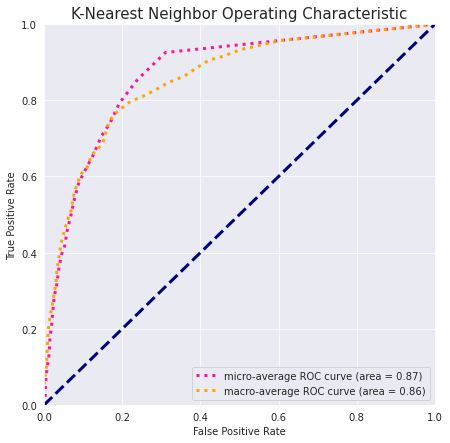

In [125]:
knn_score['roc_auc_micro'], knn_score ['roc_auc_macro'] = roc_auc_model_plot(model=knn_model, data_type=knn_data, model_name="K-Nearest Neighbor")

In [399]:
knn_score

{'cv_score': 0.4913654188948307,
 'acc_test': 0.4752475247524752,
 'adj_acc_test': 0.8118811881188119,
 'roc_auc_micro': 0.8691040553622192,
 'roc_auc_macro': 0.8557756063400587}

### D.4. Decision Tree Classification Modeling

In [89]:
def decision_tree_modeling(train_data:dict,
                           test_data:dict,
                           estimator:DecisionTreeClassifier,
                           hyper_parameter:dict) -> dict:
    dct_summary={}
    dct_highest_accuracy=0     # container for highest value of accuracy 
    for data_type in ["unbalance","rus","ros","smote"]:
        # Experiment by GridSearch CV
        decition_tree_cv = GridSearchCV(estimator=estimator, param_grid=hyper_parameter, cv=10)
        decition_tree_cv.fit(X = train_data["X_train"][data_type].values, y=train_data["y_train"][data_type])
        
        # Create the model with best params
        dct_model = DecisionTreeClassifier(criterion = decition_tree_cv.best_params_['criterion'],
                                      max_depth = decition_tree_cv.best_params_['max_depth'],
                                      min_samples_leaf = decition_tree_cv.best_params_['min_samples_leaf'],
                                      min_samples_split = decition_tree_cv.best_params_['min_samples_split'])
        
        # Fit best model to train data
        dct_model.fit(X=train_data["X_train"][data_type].values,
                           y=train_data["y_train"][data_type])
        
        # Predict output using train data
        y_train_pred  = dct_model.predict(train_data["X_train"][data_type].values)
        
        # create confusion matrix for training data
        conf_train = confusion_matrix(y_true=train_data["y_train"][data_type],
                                      y_pred=y_train_pred)
        
        # Predict output using test data
        y_test_pred = dct_model.predict(test_data['X_test'].values)
        
        
        # create confusion matrix for testing data
        conf_test = confusion_matrix(y_true=test_data['y_test'], 
                                     y_pred=y_test_pred)
        
        # summarize the modeling
        dct_summary[data_type] = {"model":dct_model, 
                                 "cv_score":decition_tree_cv.best_score_,
                                 "acc_train":accuracy(conf_train), 
                                 "adj_acc_train":accuracy_adjacent(conf_train),
                                 "acc_test": accuracy(conf_test),
                                 "adj_acc_test":accuracy_adjacent(conf_test)}
        
        # get the best model from accuracy value
        if dct_summary[data_type]["acc_test"] > dct_highest_accuracy:
            dct_highest_accuracy = dct_summary[data_type]["acc_test"]     # pass the accuracy value into a variable
            dct_best_model = dct_summary[data_type]['model']
            dct_best_data = data_type
            dct_best_score = {"cv_score" : dct_summary[data_type]["cv_score"],
                            "acc_test" : dct_summary[data_type]["acc_test"],
                           "adj_acc_test" : dct_summary[data_type]["adj_acc_test"]}
            
    return dct_summary, dct_best_model, dct_best_data, dct_best_score

In [90]:
dct_summary, dct_model, dct_data, dct_score = decision_tree_modeling(train_data=train_data,
                                                                   test_data=test_data,
                                                                   estimator=dct,
                                                                   hyper_parameter=model_hyperparameter("DecisionTreeClassifier"))

In [193]:
joblib.dump(value=dct_model, filename='pickle_data/dct_model.pkl')
dct_model

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10)

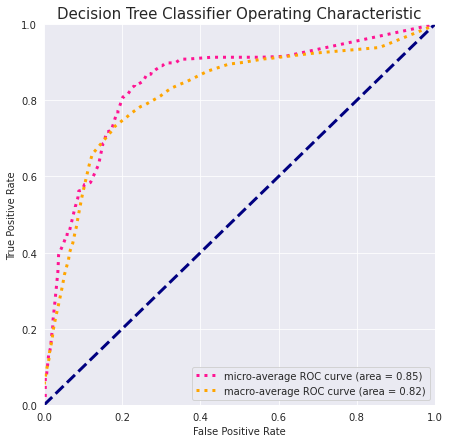

In [127]:
dct_score['roc_auc_micro'], dct_score ['roc_auc_macro'] = roc_auc_model_plot(model=dct_model, data_type=dct_data, model_name="Decision Tree Classifier")

In [400]:
dct_score

{'cv_score': 0.5367871657754011,
 'acc_test': 0.46534653465346537,
 'adj_acc_test': 0.801980198019802,
 'roc_auc_micro': 0.8454643693020292,
 'roc_auc_macro': 0.8188730390841004}

### D.5. Bagging Classifier Modeling

In [94]:
def bagging_tree_modeling(train_data:dict,
                          test_data:dict,
                          estimator:dict,
                          hyper_parameter:dict) -> dict:
    bagging_summary={}
    bagging_highest_accuracy=0
    for data_type in ["unbalance","rus","ros","smote"]:
        # Experiment by GridSearch CV
        bagging_tree = BaggingClassifier(base_estimator = estimator[data_type]['model'])
        bagging_tree_cv = GridSearchCV(estimator = bagging_tree,param_grid = hyper_parameter,cv=10)
        bagging_tree_cv.fit(X = train_data["X_train"][data_type].values,
                            y=train_data["y_train"][data_type])
        
        # Create the model with best params
        bagging_tree_model = BaggingClassifier(base_estimator = estimator[data_type]['model'],
                                                     n_estimators = bagging_tree_cv.best_params_['n_estimators'])
        # Fit best model to train data
        bagging_tree_model.fit(X=train_data["X_train"][data_type].values,
                                    y=train_data["y_train"][data_type])
        
        # Predict output using train data
        y_train_pred  = bagging_tree_model.predict(train_data["X_train"][data_type].values)
        
        # create confusion matrix for training data
        conf_train = confusion_matrix(y_true=train_data["y_train"][data_type],
                                      y_pred=y_train_pred)
        
        # Predict output using test data
        y_test_pred = bagging_tree_model.predict(test_data['X_test'].values)
        
        
        # create confusion matrix for testing data
        conf_test = confusion_matrix(y_true=test_data['y_test'], 
                                     y_pred=y_test_pred)
        
        # summarize the modeling
        bagging_summary[data_type] = {"model":bagging_tree_model, 
                                           "cv_score":bagging_tree_cv.best_score_,
                                           "acc_train":accuracy(conf_train), 
                                           "adj_acc_train":accuracy_adjacent(conf_train),
                                           "acc_test": accuracy(conf_test),
                                           "adj_acc_test":accuracy_adjacent(conf_test)}
        
        # get the best model from accuracy value
        if bagging_summary[data_type]["acc_test"] > bagging_highest_accuracy:
            bagging_highest_accuracy = bagging_summary[data_type]["acc_test"]     # pass the accuracy value into a variable
            bagging_best_model = bagging_summary[data_type]['model']
            bagging_best_data = data_type
            bagging_best_score = {"cv_score" : bagging_summary[data_type]["cv_score"],
                                  "acc_test" : bagging_summary[data_type]["acc_test"],
                                  "adj_acc_test" : bagging_summary[data_type]["adj_acc_test"]}
            
    return bagging_summary, bagging_best_model, bagging_best_data, bagging_best_score

In [95]:
bagging_summary, bagging_model, bagging_data, bagging_score = bagging_tree_modeling(train_data=train_data,
                                                                                  test_data=test_data,
                                                                                  estimator=dct_summary,
                                                                                  hyper_parameter=model_hyperparameter("BaggingClassifier"))

In [192]:
joblib.dump(value=bagging_model, filename='pickle_data/bagging_model.pkl')
bagging_model

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=4,
                                                        min_samples_split=10),
                  n_estimators=100)

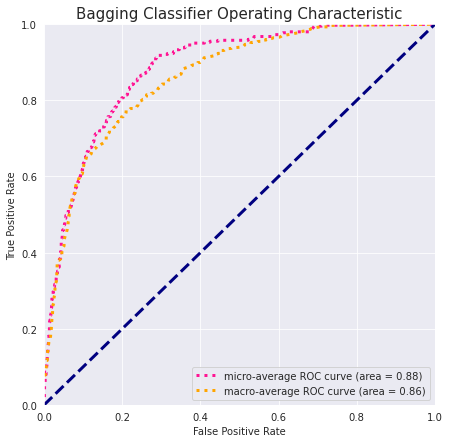

In [129]:
bagging_score['roc_auc_micro'], bagging_score ['roc_auc_macro'] = roc_auc_model_plot(model=bagging_model, data_type=bagging_data, model_name="Bagging Classifier")

In [401]:
bagging_score

{'cv_score': 0.561075935828877,
 'acc_test': 0.5099009900990099,
 'adj_acc_test': 0.8316831683168316,
 'roc_auc_micro': 0.884003789456916,
 'roc_auc_macro': 0.8619980428877464}

### D.6. Logistic Regression Modeling

In [99]:
def logistic_regression_modeling(train_data:dict,
                                 test_data:dict,
                                 estimator:LogisticRegression,
                                 hyper_parameter:dict) -> dict:
    logreg_summary={}
    logreg_highest_accuracy=0
    for data_type in ["unbalance","rus","ros","smote"]:
        # Experiment by GridSearch CV
        logreg_cv = GridSearchCV(estimator=estimator, param_grid=hyper_parameter, cv=10)
        logreg_cv.fit(X = train_data["X_train"][data_type].values, y=train_data["y_train"][data_type])
        
        # Create the model with best params
        logreg_model = LogisticRegression(penalty = logreg_cv.best_params_["penalty"],
                           max_iter = logreg_cv.best_params_["max_iter"],
                           C = logreg_cv.best_params_["C"])
        
        # Fit best model to train data
        logreg_model.fit(X=train_data["X_train"][data_type].values,
                           y=train_data["y_train"][data_type])
        
        # Predict output using train data
        y_train_pred  = logreg_model.predict(train_data["X_train"][data_type].values)
        
        # create confusion matrix for training data
        conf_train = confusion_matrix(y_true=train_data["y_train"][data_type],
                                      y_pred=y_train_pred)
        
        # Predict output using test data
        y_test_pred = logreg_model.predict(test_data['X_test'].values)
        
        
        # create confusion matrix for testing data
        conf_test = confusion_matrix(y_true=test_data['y_test'], 
                                     y_pred=y_test_pred)
        
        # summarize the modeling
        logreg_summary[data_type] = {"model":logreg_model, 
                                     "cv_score":logreg_cv.best_score_,
                                     "acc_train":accuracy(conf_train), 
                                     "adj_acc_train":accuracy_adjacent(conf_train),
                                     "acc_test": accuracy(conf_test),
                                     "adj_acc_test":accuracy_adjacent(conf_test)}
        
        # get the best model from accuracy value
        if logreg_summary[data_type]["acc_test"] > logreg_highest_accuracy:
            logreg_highest_accuracy = logreg_summary[data_type]["acc_test"]     # pass the accuracy value into a variable
            logreg_best_model = logreg_summary[data_type]['model']
            logreg_best_data = data_type
            logreg_best_score = {"cv_score" : logreg_summary[data_type]["cv_score"],
                               "acc_test" : logreg_summary[data_type]["acc_test"],
                               "adj_acc_test" : logreg_summary[data_type]["adj_acc_test"]}
            
    return logreg_summary, logreg_best_model, logreg_best_data, logreg_best_score

In [100]:
logreg_summary, logreg_model, logreg_data, logreg_score = logistic_regression_modeling(train_data=train_data,
                                                                                     test_data=test_data,
                                                                                     estimator=logreg,
                                                                                     hyper_parameter=model_hyperparameter("LogisticRegression"))

In [191]:
joblib.dump(value=dct_model, filename='pickle_data/logreg_model.pkl')
logreg_model

LogisticRegression(C=10)

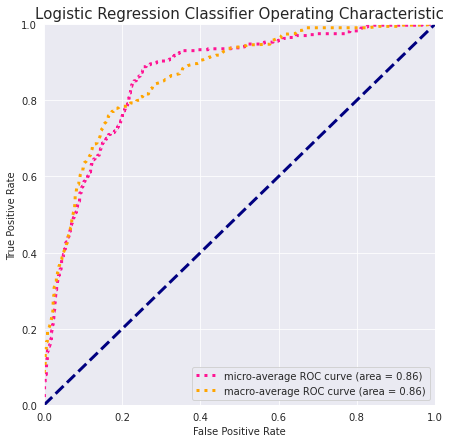

In [131]:
logreg_score['roc_auc_micro'], logreg_score ['roc_auc_macro'] = roc_auc_model_plot(model=logreg_model, data_type=logreg_data, model_name="Logistic Regression Classifier")

In [402]:
logreg_score

{'cv_score': 0.5927717202364021,
 'acc_test': 0.4975247524752475,
 'adj_acc_test': 0.8168316831683168,
 'roc_auc_micro': 0.8641723237917851,
 'roc_auc_macro': 0.8638372187754658}

### D.7. Support Vector Machine Modeling

In [104]:
def svm_modeling(train_data:dict,
                 test_data:dict,
                 estimator:SVC,
                 hyper_parameter:dict) -> dict:
    svm_summary={}
    svm_highest_accuracy=0;
    for data_type in ["unbalance","rus","ros","smote"]:
        # Experiment by GridSearch CV
        svm_cv = GridSearchCV(estimator=estimator, param_grid=hyper_parameter, cv=10)
        svm_cv.fit(X = train_data["X_train"][data_type].values, y=train_data["y_train"][data_type])
        
        # Create the model with best params
        svm_model = SVC(C=svm_cv.best_params_["C"],
                             kernel=svm_cv.best_params_["kernel"])
        
        # Fit best model to train data
        svm_model.fit(X=train_data["X_train"][data_type].values,
                           y=train_data["y_train"][data_type])
        
        # Predict output using train data
        y_train_pred  = svm_model.predict(train_data["X_train"][data_type].values)
        
        # create confusion matrix for training data
        conf_train = confusion_matrix(y_true=train_data["y_train"][data_type],
                                      y_pred=y_train_pred)
        
        # Predict output using test data
        y_test_pred = svm_model.predict(test_data['X_test'].values)
        
        
        # create confusion matrix for testing data
        conf_test = confusion_matrix(y_true=test_data['y_test'], 
                                     y_pred=y_test_pred)
        
        # summarize the modeling
        svm_summary[data_type] = {"model":svm_model, 
                                     "cv_score":svm_cv.best_score_,
                                     "acc_train":accuracy(conf_train), 
                                     "adj_acc_train":accuracy_adjacent(conf_train),
                                     "acc_test": accuracy(conf_test),
                                     "adj_acc_test":accuracy_adjacent(conf_test)}
        
        # get the best model from accuracy value
        if svm_summary[data_type]["acc_test"] > svm_highest_accuracy:
            svm_highest_accuracy = svm_summary[data_type]["acc_test"]     # pass the accuracy value into a variable
            svm_best_model = svm_summary[data_type]['model']
            svm_best_data = data_type
            svm_best_score = {"cv_score" : svm_summary[data_type]["cv_score"],
                            "acc_test" : svm_summary[data_type]["acc_test"],
                            "adj_acc_test" : svm_summary[data_type]["adj_acc_test"]}
            
    return svm_summary, svm_best_model, svm_best_data, svm_best_score

In [105]:
svm_summary, svm_model, svm_data, svm_score =svm_modeling(train_data=train_data,
                                                        test_data=test_data,
                                                        estimator=svm,
                                                        hyper_parameter=model_hyperparameter("SVC"))

In [190]:
joblib.dump(value=svm_model, filename='pickle_data/svm_model.pkl')
svm_model

SVC(C=50)

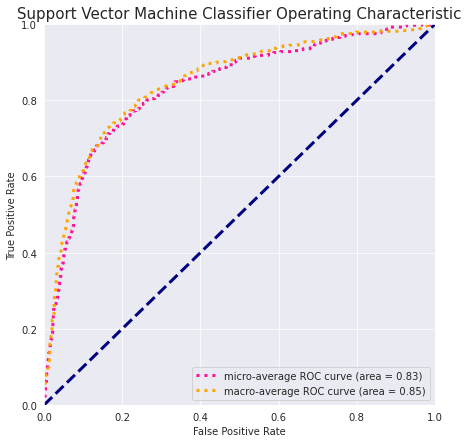

In [133]:
svm_score['roc_auc_micro'], svm_score ['roc_auc_macro'] = roc_auc_model_plot(model=svm_model, data_type=svm_data, model_name="Support Vector Machine Classifier")

In [403]:
svm_score

{'cv_score': 0.7043924022628867,
 'acc_test': 0.4801980198019802,
 'adj_acc_test': 0.8168316831683168,
 'roc_auc_micro': 0.8349357599745123,
 'roc_auc_macro': 0.8466910514575334}

### D.8. Random Forest Modeling

In [109]:
def random_forest_modeling(train_data:dict,
                                 test_data:dict,
                                 estimator:RandomForestClassifier,
                                 hyper_parameter:dict) -> dict:
    rfc_summary={}
    rfc_highest_accuracy=0;
    for data_type in ["unbalance","rus","ros","smote"]:
        # Experiment by GridSearch CV
        rfc_cv = GridSearchCV(estimator=estimator, param_grid=hyper_parameter, cv=10)
        rfc_cv.fit(X = train_data["X_train"][data_type].values, y=train_data["y_train"][data_type])
        
        # Create the model with best params
        rfc_model = RandomForestClassifier(n_estimators=rfc_cv.best_params_["n_estimators"],
                                                criterion=rfc_cv.best_params_["criterion"],
                                                min_samples_leaf=rfc_cv.best_params_["min_samples_leaf"],
                                                min_samples_split = rfc_cv.best_params_['min_samples_split'])
        
        # Fit best model to train data
        rfc_model.fit(X=train_data["X_train"][data_type].values,
                           y=train_data["y_train"][data_type])
        
        # Predict output using train data
        y_train_pred  = rfc_model.predict(train_data["X_train"][data_type].values)
        
        # create confusion matrix for training data
        conf_train = confusion_matrix(y_true=train_data["y_train"][data_type],
                                      y_pred=y_train_pred)
        
        # Predict output using test data
        y_test_pred = rfc_model.predict(test_data['X_test'].values)
        
        
        # create confusion matrix for testing data
        conf_test = confusion_matrix(y_true=test_data['y_test'], 
                                     y_pred=y_test_pred)
        
        # summarize the modeling
        rfc_summary[data_type] = {"model":rfc_model, 
                                     "cv_score":rfc_cv.best_score_,
                                     "acc_train":accuracy(conf_train), 
                                     "adj_acc_train":accuracy_adjacent(conf_train),
                                     "acc_test": accuracy(conf_test),
                                     "adj_acc_test":accuracy_adjacent(conf_test)}
        
        # get the best model from accuracy value
        if rfc_summary[data_type]["acc_test"] > rfc_highest_accuracy:
            rfc_highest_accuracy = rfc_summary[data_type]["acc_test"]     # pass the accuracy value into a variable
            rfc_best_model = rfc_summary[data_type]['model']
            rfc_best_data = data_type
            rfc_best_score = {"cv_score" : rfc_summary[data_type]["cv_score"],
                            "acc_test" : rfc_summary[data_type]["acc_test"],
                            "adj_acc_test" : rfc_summary[data_type]["adj_acc_test"]}
            
    return rfc_summary, rfc_best_model, rfc_best_data, rfc_best_score

In [110]:
rfc_summary, rfc_model, rfc_data, rfc_score = random_forest_modeling(train_data=train_data,
                                                                   test_data=test_data,
                                                                   estimator=rfc,
                                                                   hyper_parameter=model_hyperparameter('RandomForestClassifier'))

In [189]:
joblib.dump(value=rfc_model, filename='pickle_data/rfc_model.pkl')
rfc_model

RandomForestClassifier(n_estimators=10)

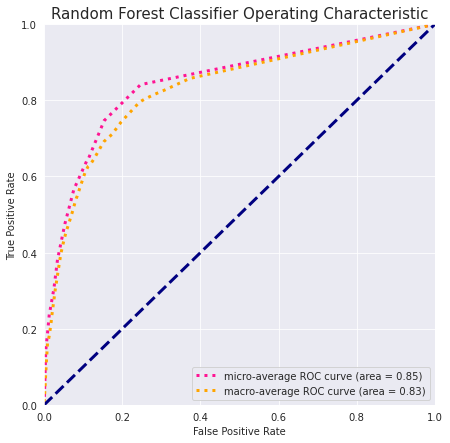

In [135]:
rfc_score['roc_auc_micro'], rfc_score ['roc_auc_macro'] = roc_auc_model_plot(model=rfc_model, data_type=rfc_data, model_name="Random Forest Classifier")

In [404]:
rfc_score

{'cv_score': 0.8934417369868211,
 'acc_test': 0.5074257425742574,
 'adj_acc_test': 0.8242574257425742,
 'roc_auc_micro': 0.8467456468728556,
 'roc_auc_macro': 0.8301369948439172}

### D.9. Extreme Gradient Boosting Modeling

In [117]:
def extreme_gradient_boosting_modeling(train_data:dict,
                                 test_data:dict,
                                 estimator:XGBClassifier,
                                 hyper_parameter:dict) -> dict:
    xgb_summary={}
    xgb_highest_accuracy=0;
    for data_type in ["unbalance","rus","ros","smote"]:
        # Experiment by GridSearch CV
        xgb_cv = GridSearchCV(estimator=estimator, param_grid=hyper_parameter, cv=10)
        xgb_cv.fit(X = train_data["X_train"][data_type].values, y=train_data["y_train"][data_type])
        
        # Create the model with best params
        xgb_model = XGBClassifier(n_estimators=xgb_cv.best_params_["n_estimators"],
                                       num_class=9)
        
        # Fit best model to train data
        xgb_model.fit(X=train_data["X_train"][data_type].values,
                           y=train_data["y_train"][data_type])
        
        # Predict output using train data
        y_train_pred  = xgb_model.predict(train_data["X_train"][data_type].values)
        
        # create confusion matrix for training data
        conf_train = confusion_matrix(y_true=train_data["y_train"][data_type],
                                      y_pred=y_train_pred)
        
        # Predict output using test data
        y_test_pred = xgb_model.predict(test_data['X_test'].values)
        
        
        # create confusion matrix for testing data
        conf_test = confusion_matrix(y_true=test_data['y_test'], 
                                     y_pred=y_test_pred)
        
        # summarize the modeling
        xgb_summary[data_type] = {"model":xgb_model, 
                                     "cv_score":xgb_cv.best_score_,
                                     "acc_train":accuracy(conf_train), 
                                     "adj_acc_train":accuracy_adjacent(conf_train),
                                     "acc_test": accuracy(conf_test),
                                     "adj_acc_test":accuracy_adjacent(conf_test)}
        
        # get the best model from accuracy value
        if xgb_summary[data_type]["acc_test"] > xgb_highest_accuracy:
            xgb_highest_accuracy = xgb_summary[data_type]["acc_test"]     # pass the accuracy value into a variable
            xgb_best_model = xgb_summary[data_type]['model']
            xgb_best_data = data_type
            xgb_best_score = {"cv_score" : xgb_summary[data_type]["cv_score"],
                            "acc_test" : xgb_summary[data_type]["acc_test"],
                            "adj_acc_test" : xgb_summary[data_type]["adj_acc_test"]}
            
    return xgb_summary, xgb_best_model, xgb_best_data, xgb_best_score

In [118]:
xgb_summary, xgb_model, xgb_data, xgb_score = extreme_gradient_boosting_modeling(train_data=train_data,
                                                                               test_data=test_data,
                                                                               estimator=xgb,
                                                                               hyper_parameter=model_hyperparameter("XGBClassifier"))

In [195]:
joblib.dump(value=xgb_model, filename='pickle_data/xgb_model.pkl')
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=5, n_jobs=0,
              num_class=9, num_parallel_tree=1, objective='multi:softprob', ...)

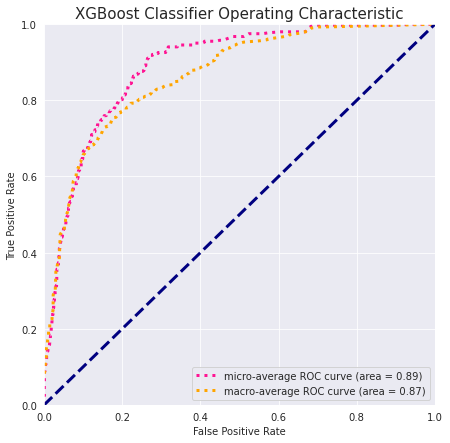

In [137]:
xgb_score['roc_auc_micro'], xgb_score ['roc_auc_macro'] = roc_auc_model_plot(model=xgb_model, data_type=xgb_data, model_name="XGBoost Classifier")

In [405]:
xgb_score

{'cv_score': 0.6085975044563281,
 'acc_test': 0.5272277227722773,
 'adj_acc_test': 0.8688118811881188,
 'roc_auc_micro': 0.8893433395010294,
 'roc_auc_macro': 0.8655005726467812}

---
## E. Summarize The Result of Modeling

### E.1 Populate Modeling Result

In [139]:
modeling_result = {"KNeighborsClassifier":{"model":knn_model, "accuracy":knn_score},
                  "DecisionTreeClassifier":{"model":dct_model, "accuracy":dct_score},
                  "BaggingClassifier":{"model":bagging_model, "accuracy":bagging_score},
                  "LogisticRegression":{"model":logreg_model, "accuracy":logreg_score},
                  "SVC":{"model":svm_model, "accuracy":svm_score},
                  "RandomForestClassifier":{"model":rfc_model, "accuracy":rfc_score},
                  "XGBClassifier":{"model":xgb_model, "accuracy":xgb_score}}

In [196]:
joblib.dump(value=modeling_result, filename='pickle_data/modeling_result.pkl')
modeling_result

{'KNeighborsClassifier': {'model': KNeighborsClassifier(algorithm='ball_tree', leaf_size=2, n_neighbors=25),
  'accuracy': {'cv_score': 0.4913654188948307,
   'acc_test': 0.4752475247524752,
   'adj_acc_test': 0.8118811881188119,
   'roc_auc_micro': 0.8691040553622192,
   'roc_auc_macro': 0.8557756063400587}},
 'DecisionTreeClassifier': {'model': DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10),
  'accuracy': {'cv_score': 0.5367871657754011,
   'acc_test': 0.46534653465346537,
   'adj_acc_test': 0.801980198019802,
   'roc_auc_micro': 0.8454643693020292,
   'roc_auc_macro': 0.8188730390841004}},
 'BaggingClassifier': {'model': BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                          min_samples_leaf=4,
                                                          min_samples_split=10),
                    n_estimators=100),
  'accuracy': {'cv_score': 0.561075935828877,
   'acc_test': 0.5099009

### E.2. Comparing Accuracy

In [165]:
model_pallet = {'XGBClassifier' : '#228B22',
               'BaggingClassifier' : '#20B2AA',
               'RandomForestClassifier': '#DC143C',
               'LogisticRegression' : '#663399',
               'SVC' : '#778899',
               'KNeighborsClassifier' : '#A0522D',
               'DecisionTreeClassifier' : '#1E90FF'}

In [141]:
def gather_accuracy_data(modeling_result:dict) -> pd.DataFrame:
    data_accuracy = {}
    for model_name in modeling_result.keys():
        data_accuracy[model_name] = modeling_result[model_name]['accuracy']['acc_test']
    data_accuracy = pd.DataFrame({"Model" : data_accuracy.keys(),
                                  "Accuracy" : data_accuracy.values()})
    return data_accuracy

In [142]:
accuracy_data = gather_accuracy_data(modeling_result)

Text(0.5, 1.0, 'Accuracy for Every Model')

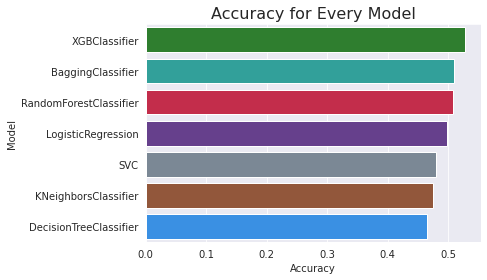

In [176]:
sns.barplot(data=accuracy_data, y="Model", x="Accuracy",
            order=accuracy_data.sort_values('Accuracy', ascending=False)["Model"],
            palette=model_pallet)
plt.title("Accuracy for Every Model", size=16)

The result of the evaluation shows that at well test data (CHURCHMAN BIBLE) all model has accuracy beneath 0.6. This is still acceptable since at the actual facies there are blended rock. From the comparison XGBClassifier has the highest accuracy on test data for 52.7% and Decision Tree Classifier has the smallest accuracy on test data for 46.5%. 

### E.3. Comparing Adjacent Accuracy

In [144]:
def gather_adjacent_accuracy_data(modeling_result:dict) -> pd.DataFrame:
    data_adjacent_accuracy = {}
    for model_name in modeling_result.keys():
        data_adjacent_accuracy[model_name] = modeling_result[model_name]['accuracy']['adj_acc_test']
    data_adjacent_accuracy = pd.DataFrame({"Model" : data_adjacent_accuracy.keys(),
                                  "Adjacent_Accuracy" : data_adjacent_accuracy.values()})
    return data_adjacent_accuracy

In [145]:
adjacent_accuracy_data = gather_adjacent_accuracy_data(modeling_result)

Text(0.5, 1.0, 'Adjacent Accuracy for Every Model')

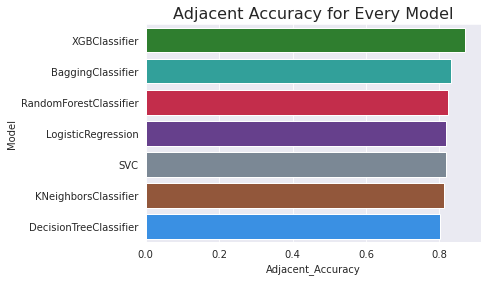

In [175]:
sns.barplot(data=adjacent_accuracy_data, y="Model", x="Adjacent_Accuracy",
            order=adjacent_accuracy_data.sort_values('Adjacent_Accuracy', ascending=False)["Model"],
            palette=model_pallet)
plt.title("Adjacent Accuracy for Every Model", size=16)

Adjacent accuracy on test data has higher value than just accuracy on test data. For all model trained the value is roughly more than 80% for adjacent facies accuracy. XGB Classifier again has the highest adjacent facies value for 86,8% and  again Decision Tree Classifier become the model with the smallest adjacent accuracy on test data for 80,2% 

### E.4. Comparing Cross Validation Score

In [147]:
def gather_cv_score_data(modeling_result:dict) -> pd.DataFrame:
    data_cv_score = {}
    for model_name in modeling_result.keys():
        data_cv_score[model_name] = modeling_result[model_name]['accuracy']['cv_score']
    data_cv_score = pd.DataFrame({"Model" : data_cv_score.keys(),
                                  "cv_score" : data_cv_score.values()})
    return data_cv_score

In [149]:
cv_score_data = gather_cv_score_data(modeling_result)

Text(0.5, 1.0, 'CV Score for Every Model')

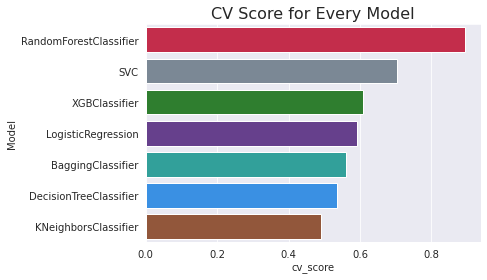

In [174]:
sns.barplot(data=cv_score_data, y="Model", x="cv_score",
            order=cv_score_data.sort_values('cv_score', ascending=False)["Model"],
            palette=model_pallet)
plt.title("CV Score for Every Model", size=16)

Cross-validation score show us that Random Forest Classifier has the highest cv-score for 89.34%, whereas KNN has the smallest cv-score for 49,1%. If we compare this cv score with the accuracy score there are much different in value from Random Forest classifier and Support Vector Machine. This is because this two model overfit in train data, hence when tested on the test data the accuracy drop from its cross validation score. There are not much different for the rest of the model, this means that the models are well trained by using train data. If we exclude the Random Forest Classifier and Support Vector Machine, XGB Classifier has the highest cv score for 60.85% where as KNN has the smallest cv score for 49,1%. 

### E.5. Comparing ROC AUC Score

In [154]:
def gather_roc_auc_macro_score_data(modeling_result:dict) -> pd.DataFrame:
    data_roc_auc_macro = {}
    for model_name in modeling_result.keys():
        data_roc_auc_macro[model_name] = modeling_result[model_name]['accuracy']['roc_auc_macro']
    data_roc_auc_macro = pd.DataFrame({"Model" : data_roc_auc_macro.keys(),
                                  "roc_auc_macro" : data_roc_auc_macro.values()})
    return data_roc_auc_macro

In [160]:
roc_auc_macro_data = gather_roc_auc_macro_score_data(modeling_result)

Text(0.5, 1.0, 'ROC AUC Macro Average Value for Every Model')

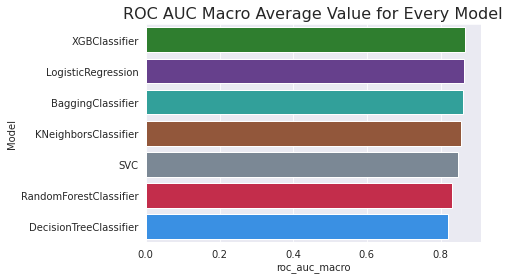

In [173]:
sns.barplot(data=roc_auc_macro_data, y="Model", x="roc_auc_macro",
            order=roc_auc_macro_data.sort_values("roc_auc_macro", ascending=False)["Model"],
            palette=model_pallet)
plt.title("ROC AUC Macro Average Value for Every Model", size=16)

---
## F. Test the Model

In [382]:
facies_label_encoder = {'SS':0, 'CSiS':1, 'FSiS':2, 'SiSh':3, 'MS':4, 'WS':5, 'D':6, 'PS':7, 'BS':8}
well_test = raw_data[raw_data['Well Name']=="CHURCHMAN BIBLE"]
well_test['Facies'] = well_test['Facies'].map(facies_label_encoder)

In [383]:
def predict_facies(well_test:pd.DataFrame, test_data:dict, modeling_result:dict) -> pd.DataFrame:
    name = ['KNN','DCT','BAGT','LOGREG','SVM',"RFC","XGB"]
    for label, model_name in zip(name,modeling_result):
        well_test[label] = modeling_result[model_name]['model'].predict(test_data['X_test'].values)
    return well_test

In [385]:
well_test = predict_facies(well_test=well_test, test_data=test_data, modeling_result=modeling_result)

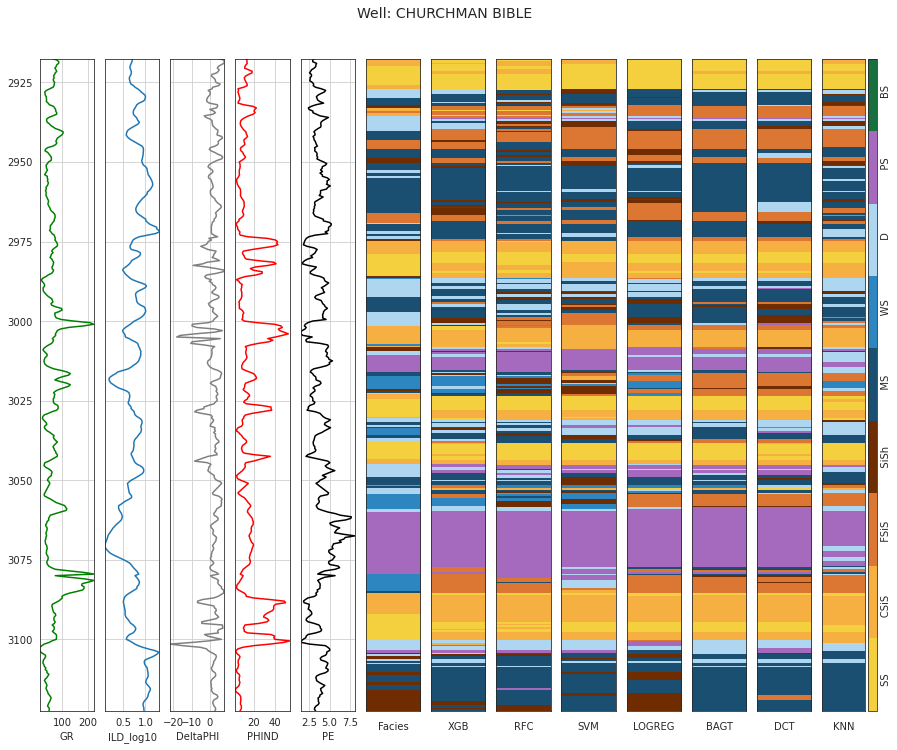

In [398]:
compare_facies_plot(well_test,"XGB","RFC","SVM","LOGREG","BAGT","DCT","KNN")